In [101]:
MOVE_PENALTY = -0.05 # -0.05
FIND_REWARD = 1.0
# Robot alwasys starts in room 0

In [144]:
import numpy as np

'''
If obs_sigma < sigma0 → you trust data more than your prior.
If obs_sigma > sigma0 → you trust your prior more than your data.
If obs_sigma = sigma0 → you give equal trust to both.
'''
# Obs sigma: confidence on observed reward
# THIS IS A META PARAMTER DEFINATELY
# SMALL (0.1 )OBS SIGMA: trust more real observations and update mu faster, sigma decreases with less uncertainty faster.
# BIG (10.0) OBS SIGMA: trust more the prior, mu updates slower. Sigma decreases slower 
def calculate_obs_sigma(rewards: list):
    mean_reward = np.mean(rewards)
    empirical_variance = np.var(rewards, ddof=1)  # ddof=1 da varianza muestral (unbiased)
    empirical_std = empirical_variance ** 0.5
    return empirical_std


In [179]:
class BayesianRewardEstimator:
    def __init__(self, mu0=3.5, sigma0=1.0, obs_sigma=0.1):
        self.mu = mu0
        self.sigma2 = sigma0 ** 2
        self.obs_sigma2 = obs_sigma ** 2
        self.n = 0
        self.sum_rewards = 0.0

    def update(self, reward):
        self.n += 1
        self.sum_rewards += reward

        precision_prior = 1 / self.sigma2
        precision_obs = self.n / self.obs_sigma2

        self.sigma2 = 1 / (precision_prior + precision_obs)
        self.mu = self.sigma2 * (precision_prior * self.mu + (self.sum_rewards / self.obs_sigma2))
        #print("update belief finish")

    def current_posterior(self):
        return self.mu, self.sigma2 ** 0.5


## EXPERIMENT SETUP: BALLS IN ROOMS

In [3]:
class BallEnvDetectable:
    def __init__(self,num_rooms=4, num_blue=3, num_red=1):
        self.num_rooms = num_rooms
        self.num_blue = num_blue
        self.num_red = num_red
        self.balls = []
        self.found_balls = set()
        self.robot_room = 0
        self.blue_cluster_prob = 0.9
        self.p_detect = 0.9
        self.p_explore = 0.1
        self.connections = self._default_connections()

    def _default_connections(self):
        # Conexión por defecto: todos conectados con todos (completo)
        return {i: [j for j in range(self.num_rooms) if j != i] for i in range(self.num_rooms)}

    def set_blue_cluster_prob(self, prob: float):
        self.blue_cluster_prob = prob

    def set_detection_params(self, p_detect: float, p_explore: float):
        self.p_detect = p_detect
        self.p_explore = p_explore

    def set_manual_ball_positions(self, positions: list[tuple[str, int]]):
        self.balls = positions.copy()
        self.found_balls = set()

    def set_connections(self, connections: dict[int, list[int]]):
        """
        Define conexiones entre habitaciones. Ejemplo:
        {
            0: [1],
            1: [0, 2],
            2: [1, 3],
            3: [2]
        }
        """
        self.connections = connections

    def reset(self):
        self.found_balls = set()

        if not self.balls:
            self.balls = []

            if random.random() < self.blue_cluster_prob:
                blue_room = random.randint(0, self.num_rooms - 1)
                for _ in range(self.num_blue):
                    self.balls.append(('blue', blue_room))
            else:
                for _ in range(self.num_blue):
                    self.balls.append(('blue', random.randint(0, self.num_rooms - 1)))

            for _ in range(self.num_red):
                self.balls.append(('red', random.randint(0, self.num_rooms - 1)))

        self.robot_room = 0 # Robot alwasys starts in room 0
        #random.randint(0, self.num_rooms - 1)
        return self.robot_room

    def detect_ball(self):
        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    return i, color
        return None

    def step(self, target_room):
        if target_room not in self.connections.get(self.robot_room, []):
            raise ValueError(f"Invalid move: no connection from Room {self.robot_room} to Room {target_room}")

        reward = MOVE_PENALTY
        self.robot_room = target_room
        ball_found = None

        for i, (color, room) in enumerate(self.balls):
            if room == self.robot_room and i not in self.found_balls:
                if random.random() < self.p_detect:
                    self.found_balls.add(i)
                    reward += FIND_REWARD
                    ball_found = (i, color)
                break

        done = len(self.found_balls) == len(self.balls)
        return self.robot_room, reward, done, ball_found


## POLICY DEFINITION STAY IF BLUE BALL DETECTED

In [4]:
# Versión sin modificar de run_policy_with_detection pero que permite pasar un estimador bayesiano opcional
import random
import numpy as np  # si usas operaciones de numpy también


def run_policy_with_detection(env: BallEnvDetectable, max_steps=50, estimator=None):
    state = env.reset()
    total_reward = 0
    steps_taken = 0
    visited = set()
    empty_rooms = set()
    blue_rooms_memory = set()
    found_ids_last_step = set()

    print("\n🧪 Initial ball positions:")
    for i, (color, room) in enumerate(env.balls):
        print(f"   Ball {i}: {color.upper()} in Room {room}")
    print(f"\n🚀 Robot starting in Room {state}\n")

    for _ in range(max_steps):
        visited.add(state)

        # Detectar si hay una bola visible (probabilística)
        detection = env.detect_ball()

        if detection:
            idx, color = detection
            print(f"👁️  Detected possible {color.upper()} ball in Room {state}")
        else:
            print(f"🙈 No balls detected in Room {state}")

        # Decidir acción
        if detection and color == "blue":
            if random.random() < env.p_explore:
                # Explorar otra sala aunque haya azul
                candidate_rooms = [r for r in range(env.num_rooms) if r != state and r not in empty_rooms]
                if not candidate_rooms:
                    candidate_rooms = [r for r in range(env.num_rooms) if r != state]
                next_room = random.choice(candidate_rooms)
                print(f"   🤷 Exploring another room despite seeing blue.")
            else:
                next_room = state  # quedarse
        elif detection:
            next_room = state  # quedarse por bola no azul
        else:
            candidate_rooms = [r for r in range(env.num_rooms) if r != state and r not in empty_rooms]
            if not candidate_rooms:
                candidate_rooms = [r for r in range(env.num_rooms) if r != state]
            next_room = random.choice(candidate_rooms)

        # Paso de entorno
        prev_state = state
        state, reward, done, ball_found = env.step(next_room)
        total_reward += reward
        steps_taken += 1

        print(f"🔄 STEP {steps_taken} — Moved from Room {prev_state} → Room {next_room}")

        if ball_found:
            idx, color = ball_found
            print(f"   🎯 Found new ball: {color.upper()} (ID {idx})")
            if color == "blue":
                blue_rooms_memory.add(state)
        else:
            print(f"   😐 No new balls found in this room")

        # Si no encontró nada, marcar como vacía
        remaining_unknown = any(
            room == state and i not in env.found_balls for i, (_, room) in enumerate(env.balls)
        )
        if not ball_found and not remaining_unknown:
            empty_rooms.add(state)
            print(f"   🧱 Marking Room {state} as empty.")

        print(f"   💰 Reward: {reward:.2f} | Total: {total_reward:.2f}")
        print(f"   ✅ Balls found: {len(env.found_balls)} / 4")
        print(f"   🗺️  Visited: {sorted(visited)} | Empty: {sorted(empty_rooms)} | Memory(Blue): {sorted(blue_rooms_memory)}")
        print("---------------------------------------------------\n")

        if done:
            print("🎉 ✅ All balls found!")
            break
    else:
        print("⚠️ Max steps reached without finding all balls.")

    print(f"🏁 Finished after {steps_taken} steps | Total reward: {total_reward:.2f}")

    if estimator:
        print(f"🔢 Updating with total reward: {total_reward:.2f}")

        estimator.update(total_reward)

    plot_room_ball_distribution(env)
    return total_reward, steps_taken



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def plot_room_ball_distribution(env: BallEnvDetectable):
    ball_count = np.zeros(env.num_rooms, dtype=int)
    ball_labels = [[] for _ in range(env.num_rooms)]

    for i, (color, room) in enumerate(env.balls):
        ball_count[room] += 1
        label = color[0].upper()
        if i in env.found_balls:
            label += '✓'
        ball_labels[room].append(label)

    ball_labels[env.robot_room].append("🤖")

    # Calcular dimensiones cuadradas más cercanas para el reshape dinámico
    rows = math.floor(math.sqrt(env.num_rooms))
    cols = math.ceil(env.num_rooms / rows)

    # Ajustar a tamaño correcto rellenando si es necesario
    total_cells = rows * cols
    if total_cells > env.num_rooms:
        ball_count = np.concatenate([ball_count, np.zeros(total_cells - env.num_rooms, dtype=int)])
        ball_labels += [''] * (total_cells - env.num_rooms)

    grid = ball_count.reshape((rows, cols))
    label_grid = np.array([
        '\n'.join(ball_labels[i]) if isinstance(ball_labels[i], list) else ''
        for i in range(total_cells)
    ]).reshape((rows, cols))

    plt.figure(figsize=(cols + 2, rows + 2))
    ax = sns.heatmap(grid, annot=label_grid, fmt='', cmap="YlGnBu", cbar=False,
                     linewidths=1, linecolor='gray', square=True)

    for y in range(rows):
        for x in range(cols):
            room_id = y * cols + x
            if room_id < env.num_rooms:
                ax.text(x + 0.5, y + 0.9, f"Room {room_id}", color='black',
                        ha='center', va='bottom', fontsize=9)

    plt.title("Room Map with Ball Distribution")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()


## EXPERIMENT SETUP - RUN POLICY STAY IF BLUE BALL FOUND 

📌 Prior belief: μ₀ = 3.65, σ₀ = 0.0200

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
--------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


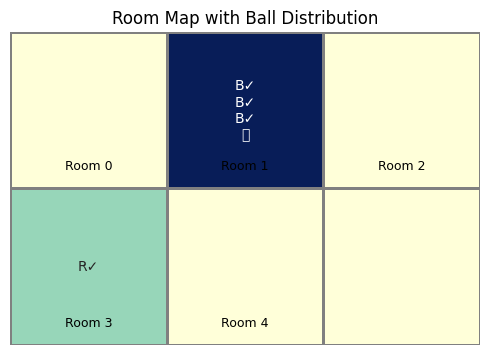

📌 Posterior belief: μ = 3.65, σ = 0.0196


In [162]:
# Bayesian prior belief
est = BayesianRewardEstimator(mu0=3.65, sigma0=0.02, obs_sigma=0.1) # obs_sigma=0.5 observations are reliable
print(f"📌 Prior belief: μ₀ = {est.mu:.2f}, σ₀ = {est.sigma2 ** 0.5:.4f}")
# Number of balls in each room by color
NUM_ROOMS = 5
env = BallEnvDetectable(NUM_ROOMS,num_blue=3, num_red=1)
# Probability that blue balls are all in the same room
env.set_blue_cluster_prob(0.9) # 0.9
# Probability of sucesful local detection and exploration chance out of blue room even when blue ball detected.
env.set_detection_params(p_detect=0.9, p_explore=0.0)

'''
env.set_connections({
    0: [0, 1, 2, 3],
    1: [0, 1, 2, 3],
    2: [0, 1, 2, 3],
    3: [0, 1, 2, 3]
})
'''

all_to_all = {i: list(range(NUM_ROOMS)) for i in range(NUM_ROOMS)}
env.set_connections(all_to_all)
# Manual setup of ball location

''' original
env.set_manual_ball_positions([
    ('blue', 1), ('blue', 1), ('blue', 1),  # tres bolas azules
    ('red', 4)                              # una roja
])
'''

env.set_manual_ball_positions([
    ('blue', 1), ('blue', 1), ('blue', 1),  # tres bolas azules
    ('red', 3)                              # una roja
])


# Running policy 1, location
run_policy_with_detection(env, estimator=est)
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")


## RUNNING POLICY 1 many times

📌 Prior belief: μ₀ = 3.65, σ₀ = 0.0210

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
----------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


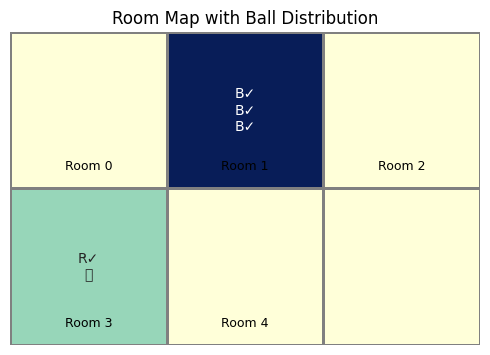

📌 Posterior belief: μ = 3.65, σ = 0.0206

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


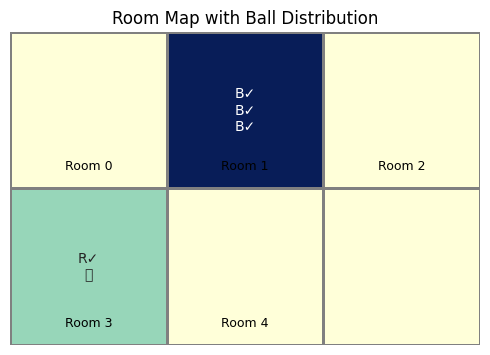

📌 Posterior belief: μ = 3.66, σ = 0.0197

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


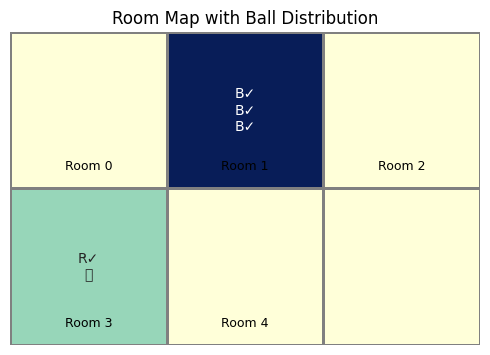

📌 Posterior belief: μ = 3.66, σ = 0.0187

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [0, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


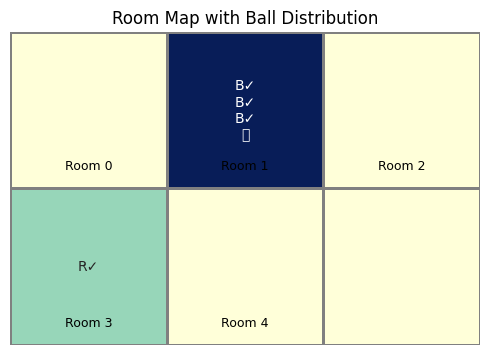

📌 Posterior belief: μ = 3.66, σ = 0.0175

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


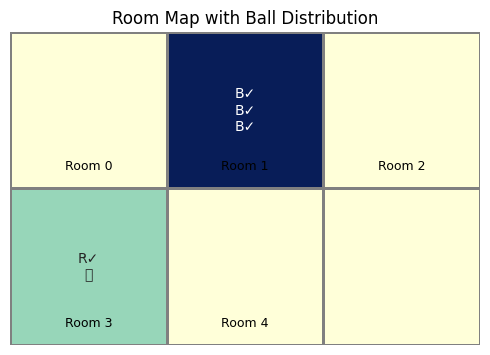

📌 Posterior belief: μ = 3.66, σ = 0.0163

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   😐 No new balls found in this room
   🧱 Marking Room 3 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 3] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


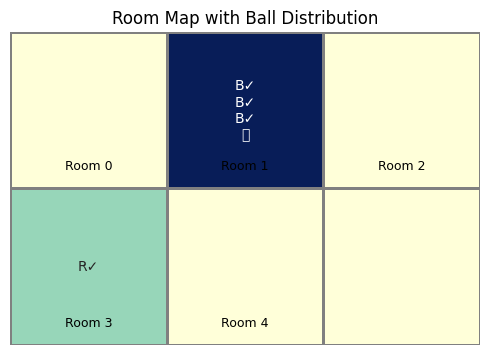

📌 Posterior belief: μ = 3.67, σ = 0.0151

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): []
------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


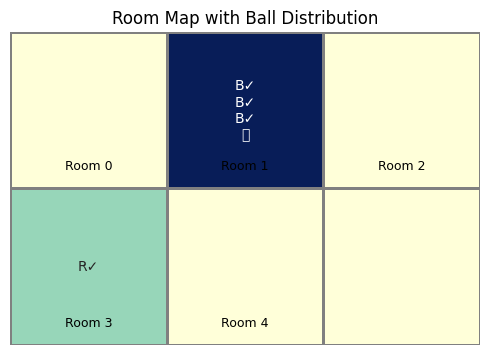

📌 Posterior belief: μ = 3.66, σ = 0.0140

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


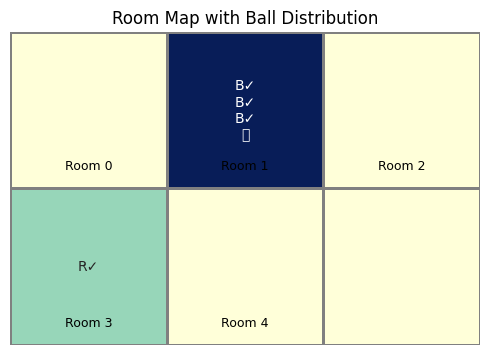

📌 Posterior belief: μ = 3.66, σ = 0.0131

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


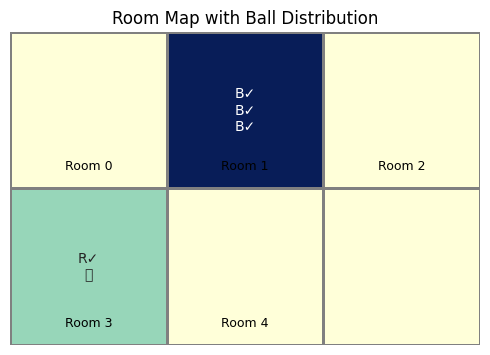

📌 Posterior belief: μ = 3.66, σ = 0.0122

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


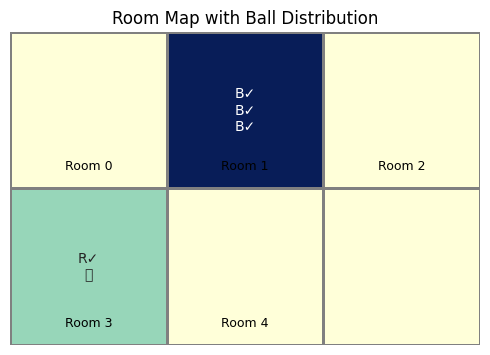

📌 Posterior belief: μ = 3.66, σ = 0.0113

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [4] | Memory(Blue): [1]
------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


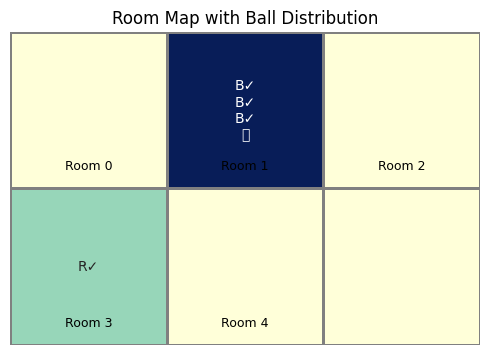

📌 Posterior belief: μ = 3.66, σ = 0.0106

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


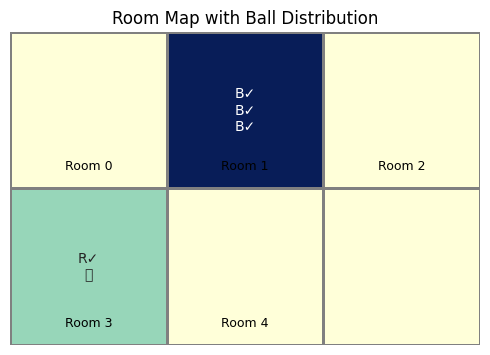

📌 Posterior belief: μ = 3.67, σ = 0.0100

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


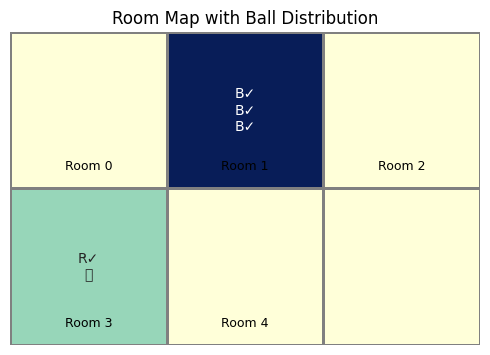

📌 Posterior belief: μ = 3.67, σ = 0.0094

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


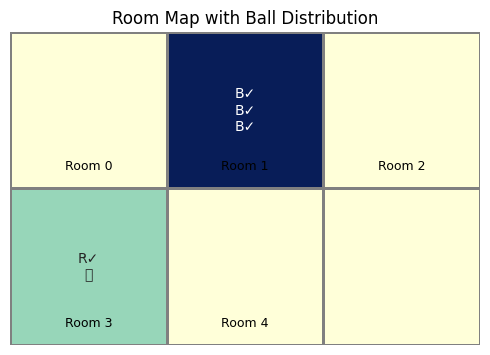

📌 Posterior belief: μ = 3.67, σ = 0.0089

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


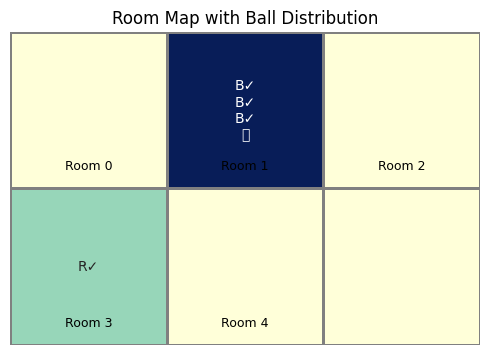

📌 Posterior belief: μ = 3.67, σ = 0.0084

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

🙈 No balls detected in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


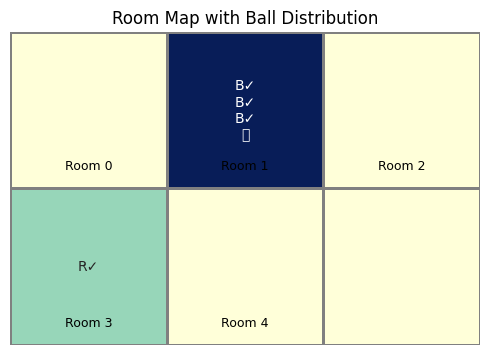

📌 Posterior belief: μ = 3.67, σ = 0.0079

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


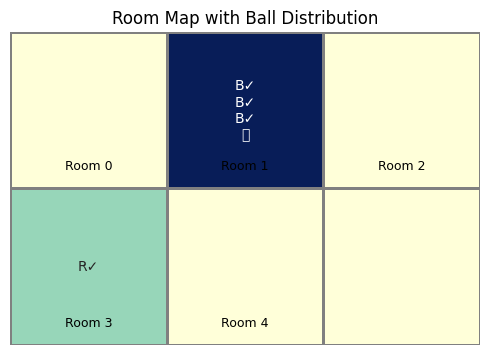

📌 Posterior belief: μ = 3.67, σ = 0.0075

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


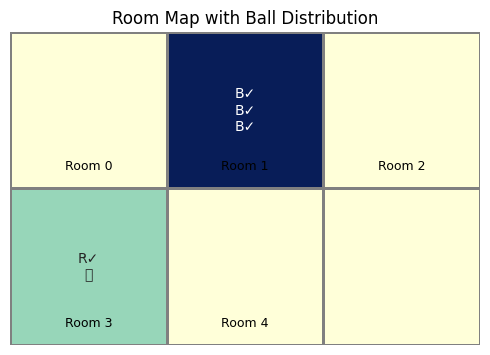

📌 Posterior belief: μ = 3.67, σ = 0.0072

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


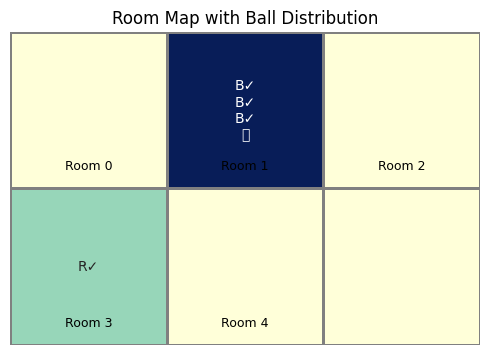

📌 Posterior belief: μ = 3.67, σ = 0.0069

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
--------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


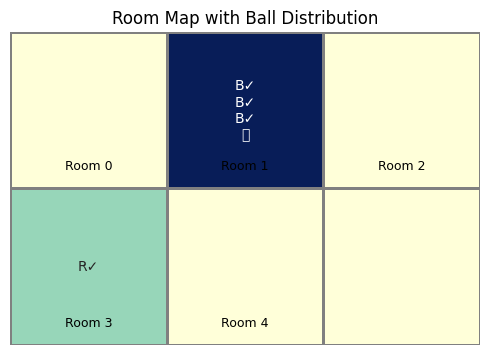

📌 Posterior belief: μ = 3.67, σ = 0.0066

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


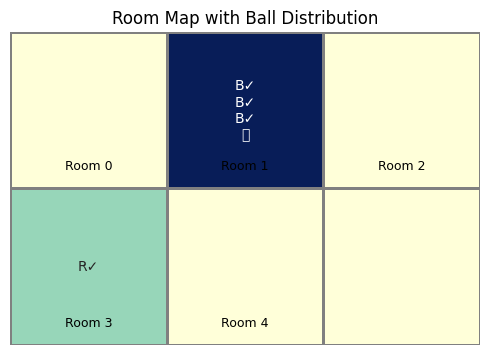

📌 Posterior belief: μ = 3.67, σ = 0.0063

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 2] | Empty: [2] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


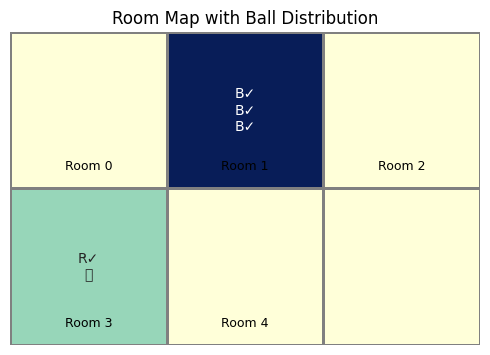

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.67, σ = 0.0060

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


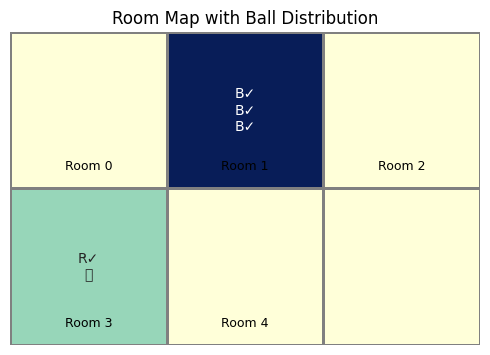

📌 Posterior belief: μ = 3.66, σ = 0.0058

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


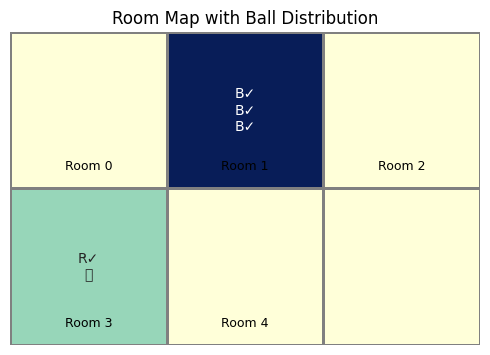

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.66, σ = 0.0056

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


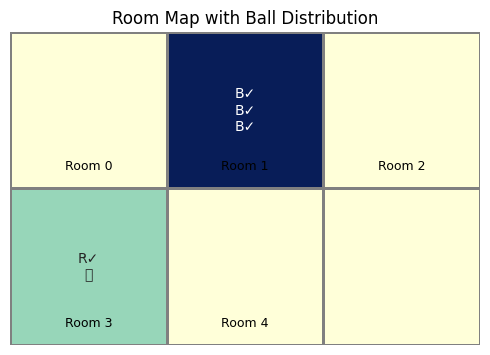

📌 Posterior belief: μ = 3.66, σ = 0.0054

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


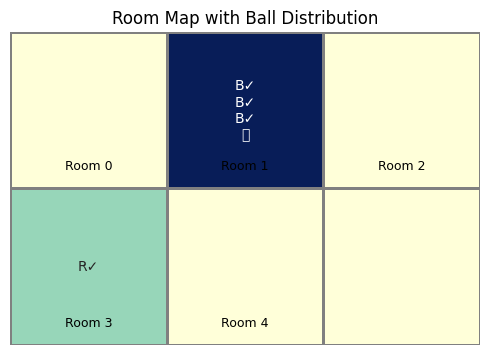

📌 Posterior belief: μ = 3.66, σ = 0.0052

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
------------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


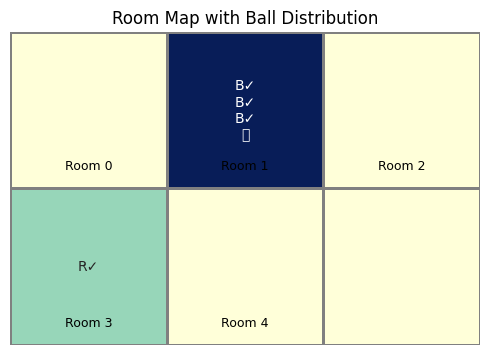

📌 Posterior belief: μ = 3.66, σ = 0.0050

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [0, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


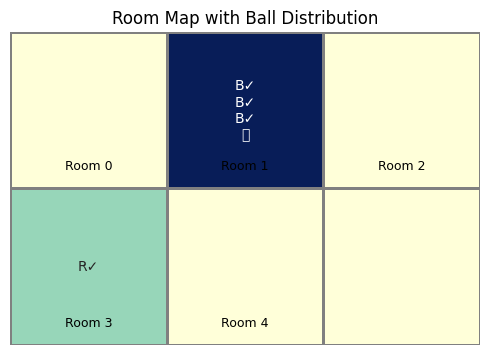

📌 Posterior belief: μ = 3.66, σ = 0.0048

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


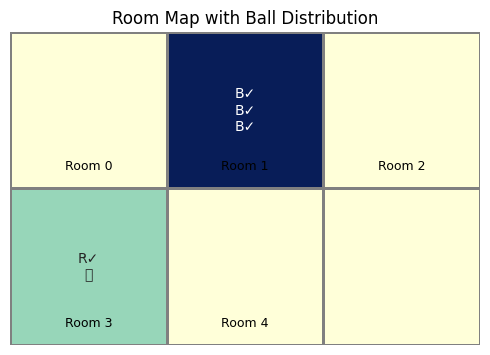

📌 Posterior belief: μ = 3.66, σ = 0.0047

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   😐 No new balls found in this room
   🧱 Marking Room 3 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 3] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


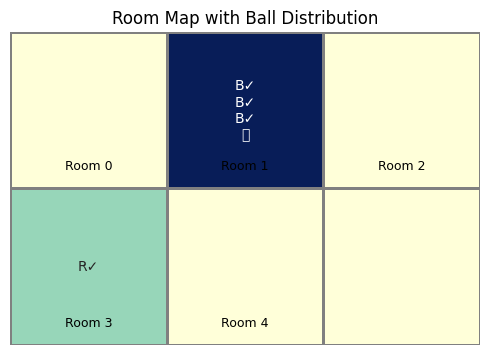

📌 Posterior belief: μ = 3.66, σ = 0.0045

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [0, 2] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


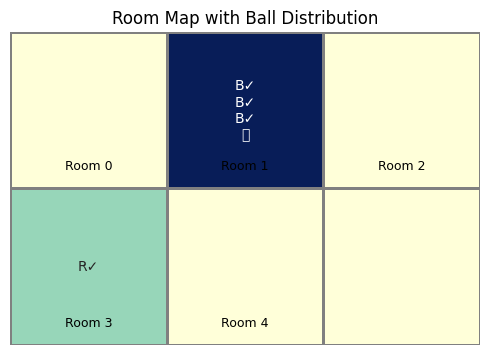

📌 Posterior belief: μ = 3.66, σ = 0.0044

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
------------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


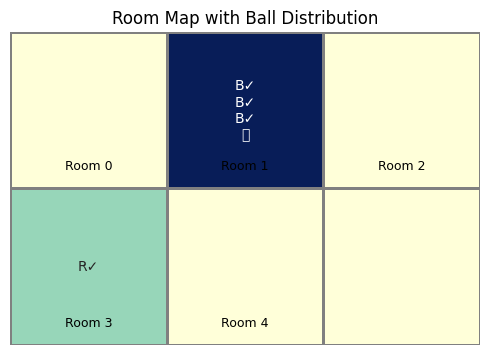

📌 Posterior belief: μ = 3.67, σ = 0.0043

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


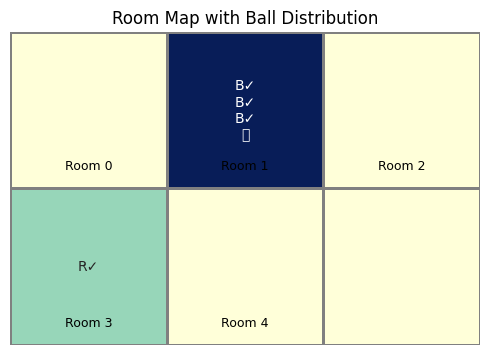

📌 Posterior belief: μ = 3.67, σ = 0.0041

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


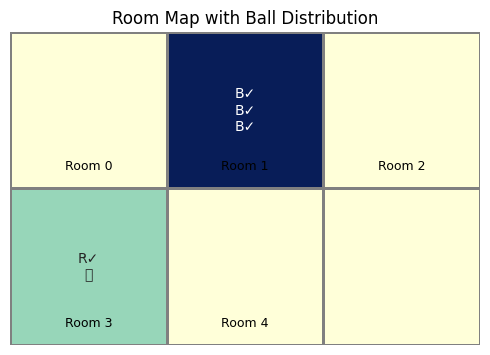

📌 Posterior belief: μ = 3.67, σ = 0.0040

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


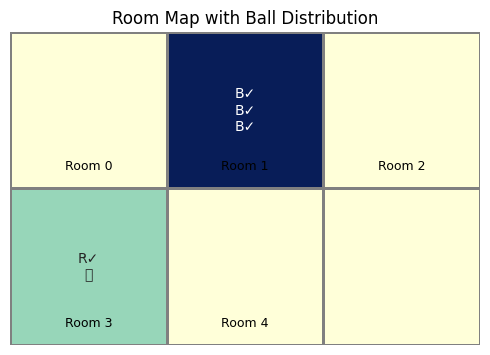

📌 Posterior belief: μ = 3.67, σ = 0.0039

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1, 2] | Empty: [2] | Memory(Blue): [1]
---

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


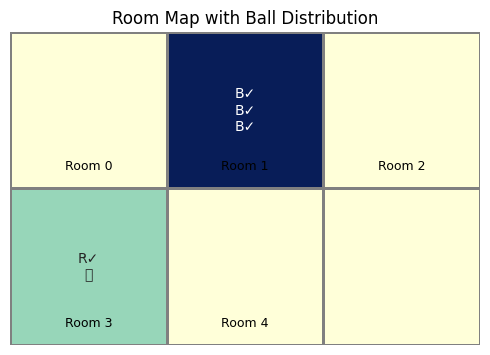

📌 Posterior belief: μ = 3.67, σ = 0.0038

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


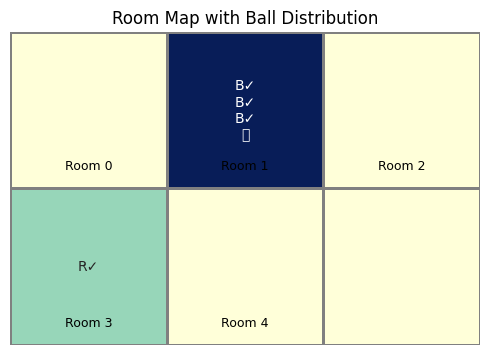

📌 Posterior belief: μ = 3.67, σ = 0.0037

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


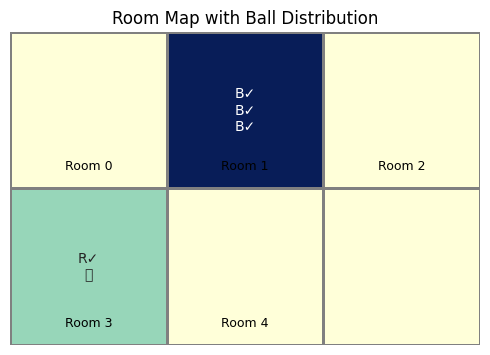

📌 Posterior belief: μ = 3.67, σ = 0.0036

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


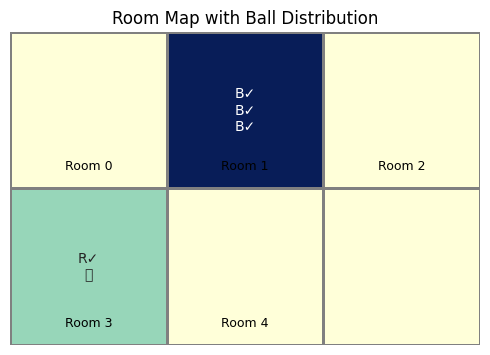

📌 Posterior belief: μ = 3.67, σ = 0.0035

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [2, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


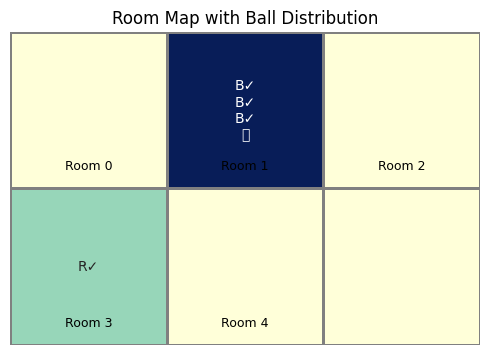

📌 Posterior belief: μ = 3.67, σ = 0.0034

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
-------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


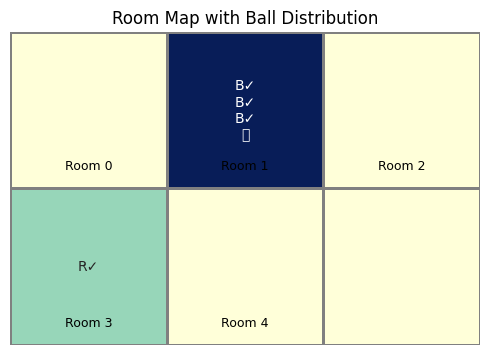

📌 Posterior belief: μ = 3.67, σ = 0.0034

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


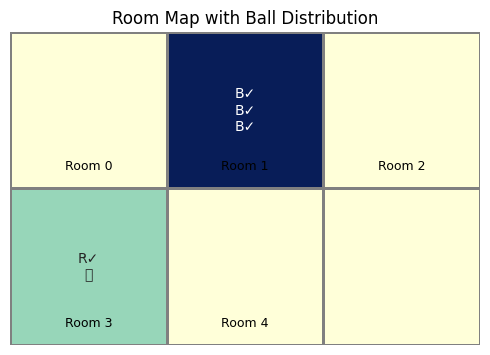

📌 Posterior belief: μ = 3.67, σ = 0.0033

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


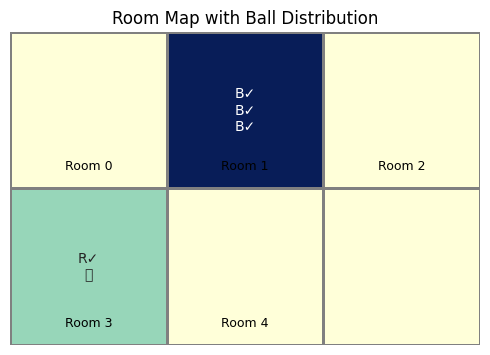

📌 Posterior belief: μ = 3.67, σ = 0.0032

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


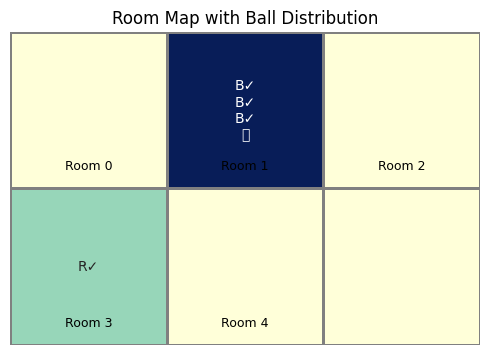

📌 Posterior belief: μ = 3.67, σ = 0.0031

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


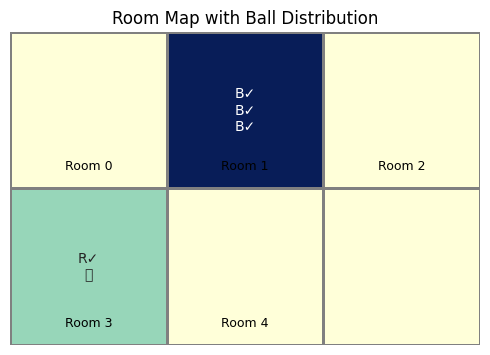

📌 Posterior belief: μ = 3.67, σ = 0.0031

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


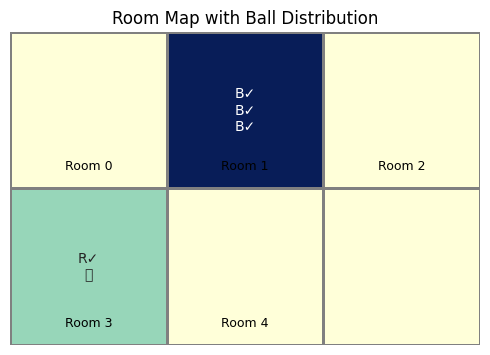

📌 Posterior belief: μ = 3.67, σ = 0.0030

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


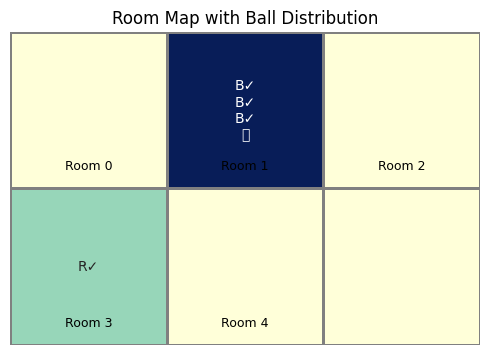

📌 Posterior belief: μ = 3.67, σ = 0.0029

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | M

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


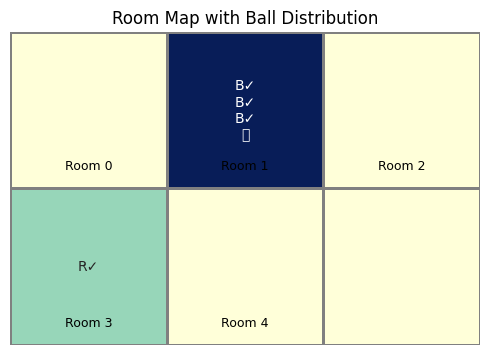

📌 Posterior belief: μ = 3.67, σ = 0.0029

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


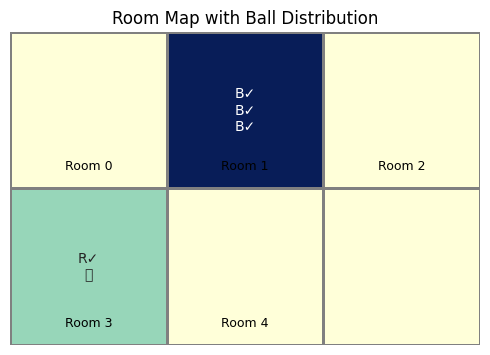

📌 Posterior belief: μ = 3.67, σ = 0.0028

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [0, 2] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


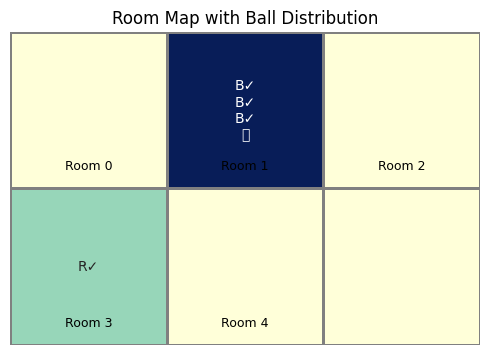

📌 Posterior belief: μ = 3.67, σ = 0.0028

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


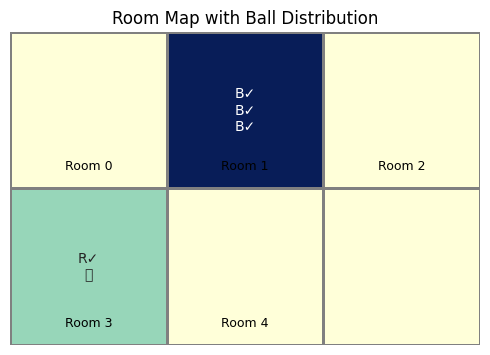

📌 Posterior belief: μ = 3.67, σ = 0.0027

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


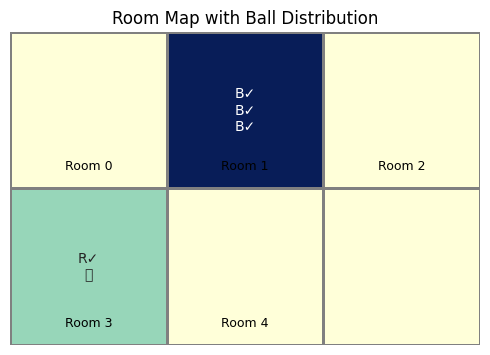

📌 Posterior belief: μ = 3.67, σ = 0.0027

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2, 4] | Empty: 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


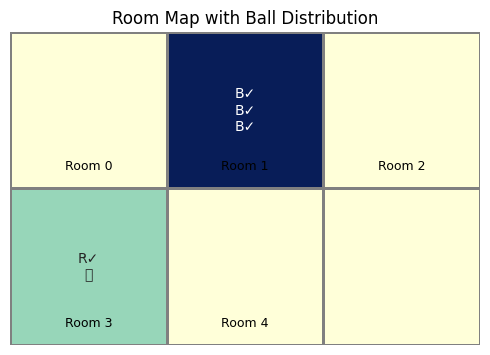

📌 Posterior belief: μ = 3.67, σ = 0.0026

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

🙈 No balls detected in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


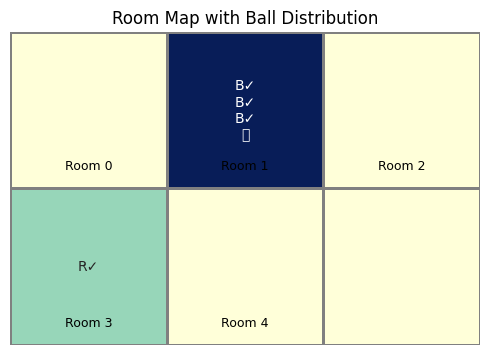

📌 Posterior belief: μ = 3.67, σ = 0.0026

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
--------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


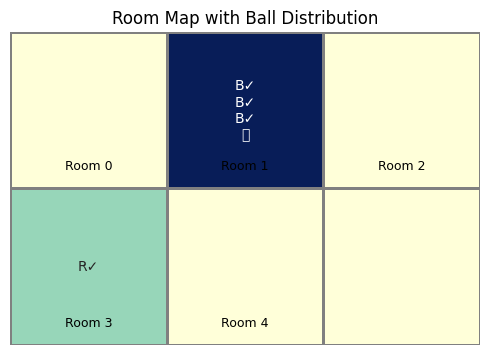

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.67, σ = 0.0025

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 4] | Memo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


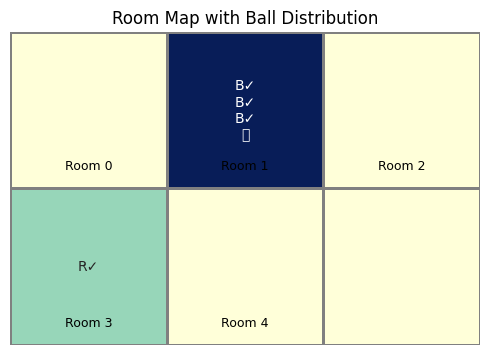

📌 Posterior belief: μ = 3.67, σ = 0.0025

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


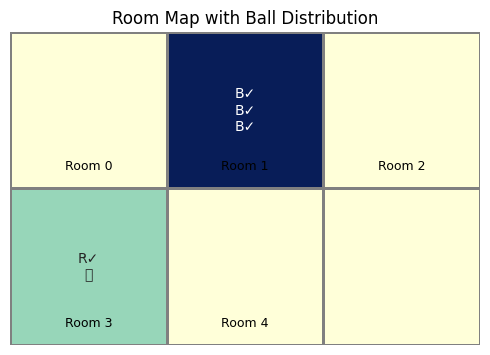

📌 Posterior belief: μ = 3.67, σ = 0.0024

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0, 2] | Memory(

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


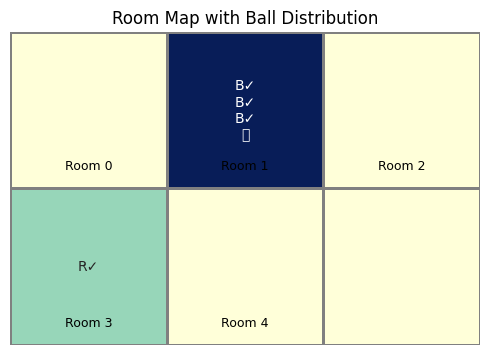

📌 Posterior belief: μ = 3.67, σ = 0.0024

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


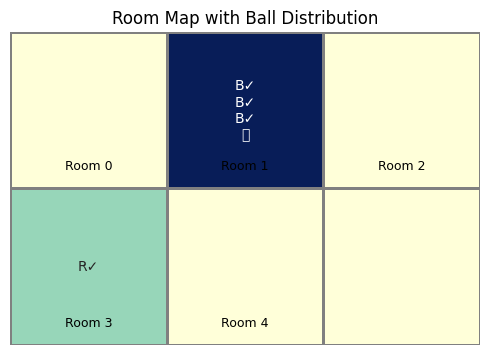

📌 Posterior belief: μ = 3.67, σ = 0.0024

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0, 4] | Memory(

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


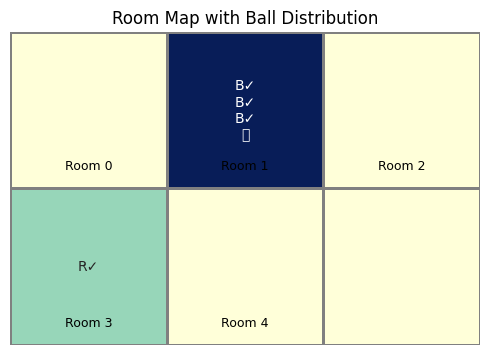

📌 Posterior belief: μ = 3.67, σ = 0.0023

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


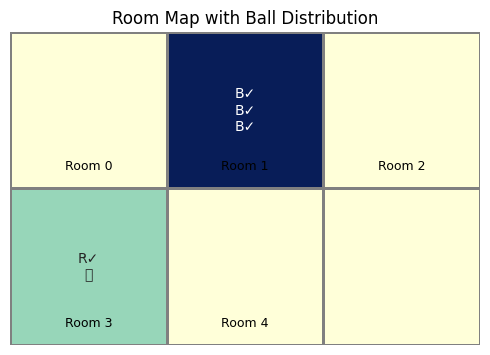

📌 Posterior belief: μ = 3.67, σ = 0.0023

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | M

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


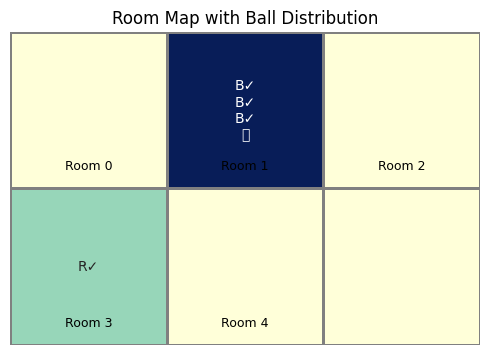

📌 Posterior belief: μ = 3.67, σ = 0.0022

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

🙈 No balls detected in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [2] | Memory(Blue): [1]
-------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


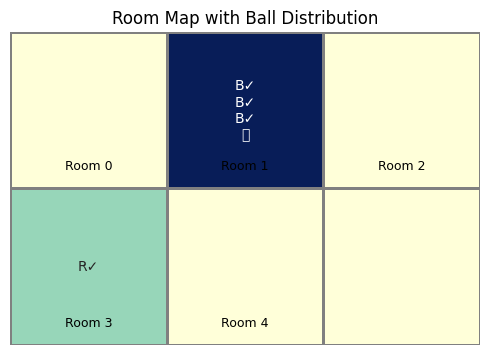

📌 Posterior belief: μ = 3.67, σ = 0.0022

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


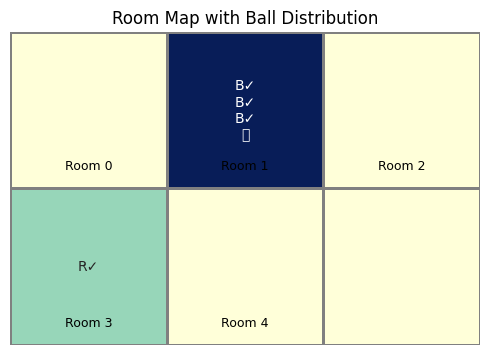

📌 Posterior belief: μ = 3.67, σ = 0.0022

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 3
   😐 No new balls found in this room
   🧱 Marking Room 3 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [0, 3] | Memory(

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


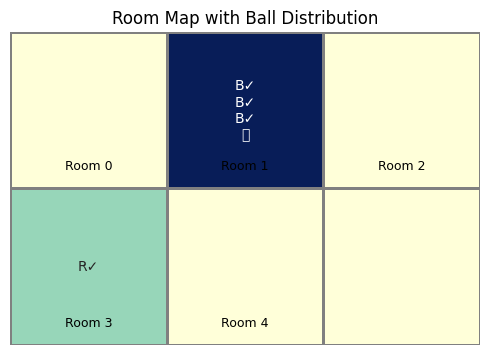

📌 Posterior belief: μ = 3.67, σ = 0.0021

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


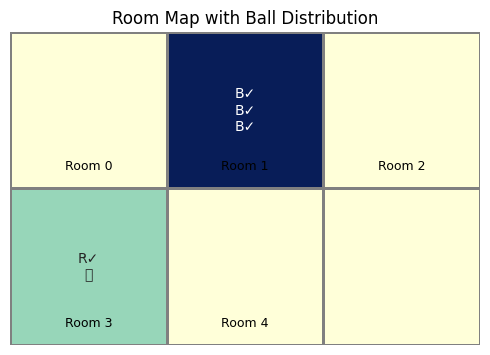

📌 Posterior belief: μ = 3.67, σ = 0.0021

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 3
   😐 No new balls found in this room
   🧱 Marking Room 3 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [3, 4] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


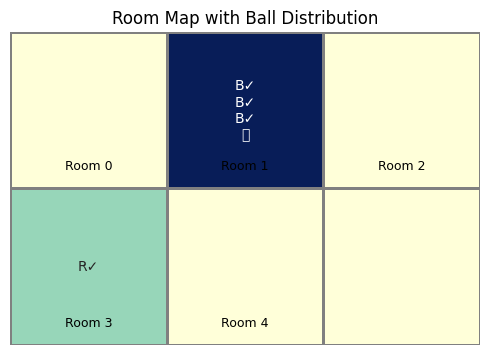

📌 Posterior belief: μ = 3.67, σ = 0.0021

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


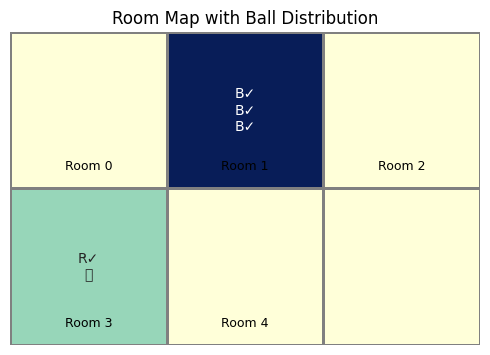

📌 Posterior belief: μ = 3.67, σ = 0.0021

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


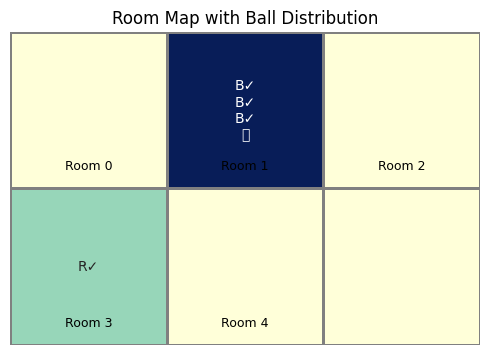

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.67, σ = 0.0020

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


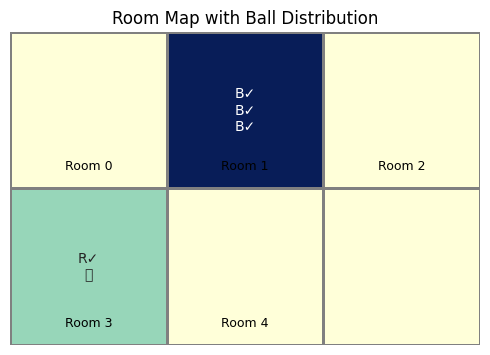

📌 Posterior belief: μ = 3.67, σ = 0.0020

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


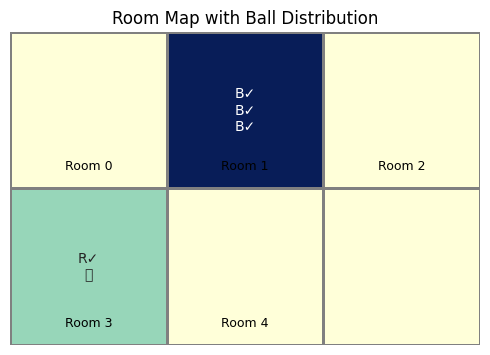

📌 Posterior belief: μ = 3.67, σ = 0.0020

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


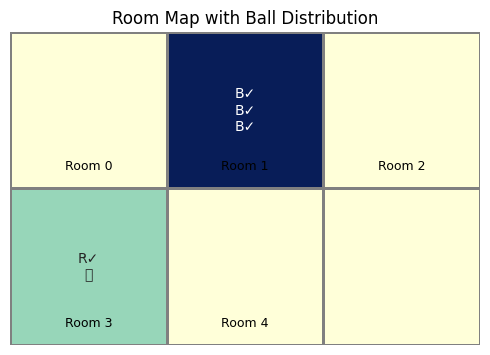

📌 Posterior belief: μ = 3.67, σ = 0.0019

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


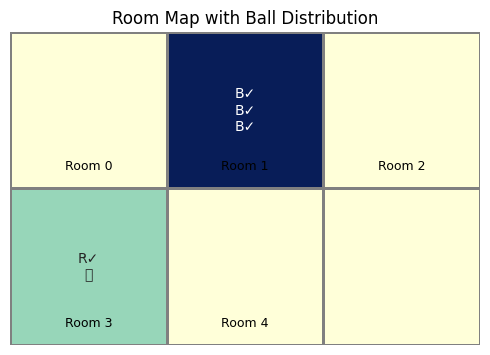

📌 Posterior belief: μ = 3.67, σ = 0.0019

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


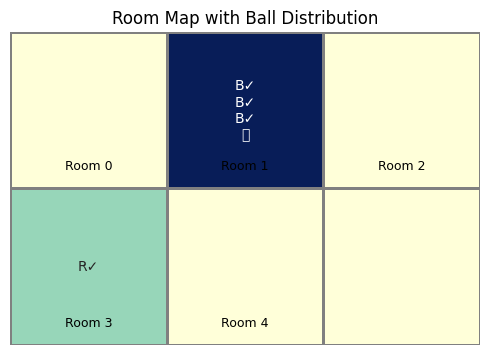

📌 Posterior belief: μ = 3.67, σ = 0.0019

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


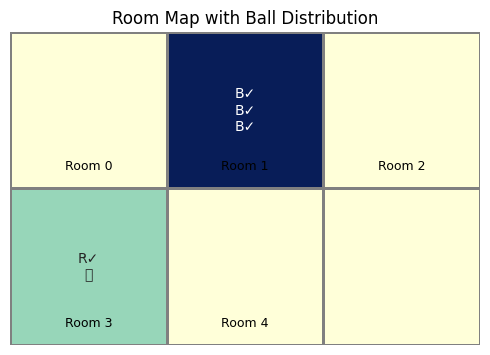

📌 Posterior belief: μ = 3.67, σ = 0.0019

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


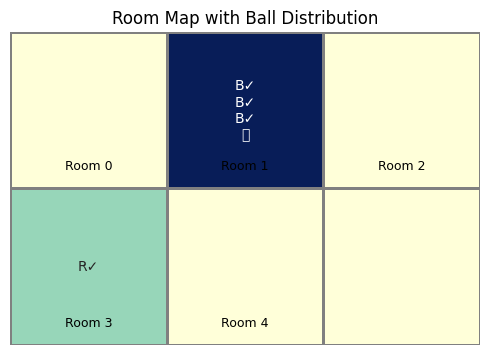

📌 Posterior belief: μ = 3.67, σ = 0.0018

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
----------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


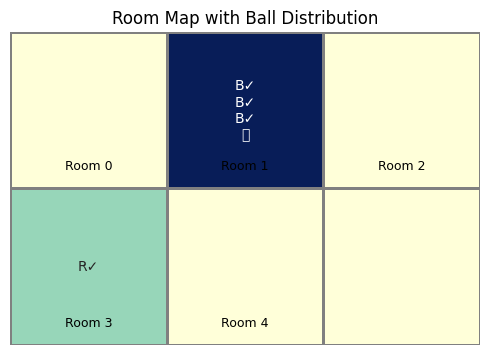

📌 Posterior belief: μ = 3.67, σ = 0.0018

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1, 3] | Empty: [] | Memory(Blue): [1]
------------------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


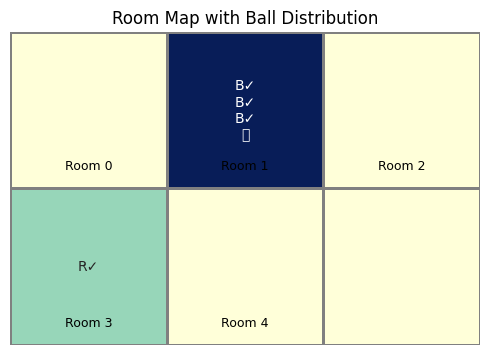

📌 Posterior belief: μ = 3.67, σ = 0.0018

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible RED ball in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [] | Memory(Blue): []
-------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


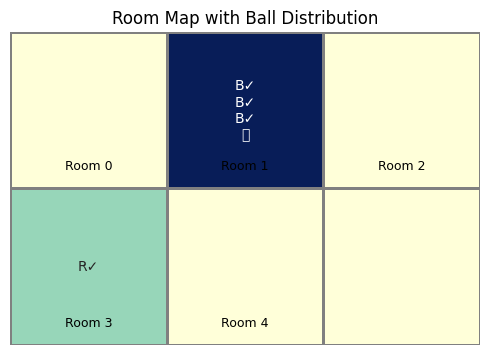

📌 Posterior belief: μ = 3.67, σ = 0.0018

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
---

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


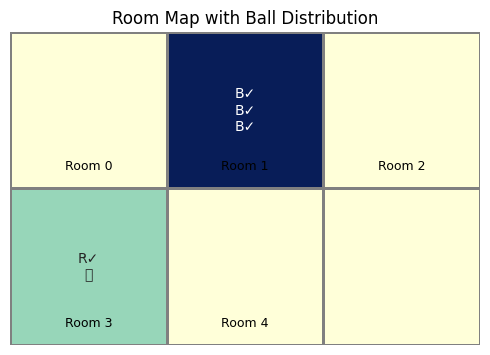

📌 Posterior belief: μ = 3.67, σ = 0.0018

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2] | Memory(Blue): [1]
------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


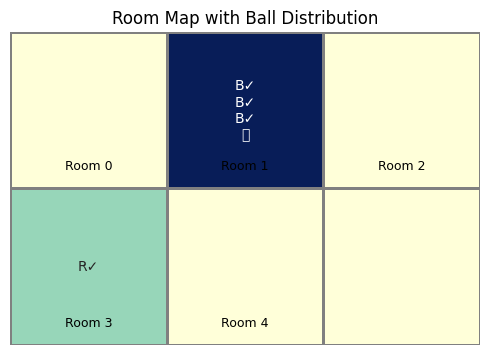

📌 Posterior belief: μ = 3.67, σ = 0.0017

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2, 4] | Empty: 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


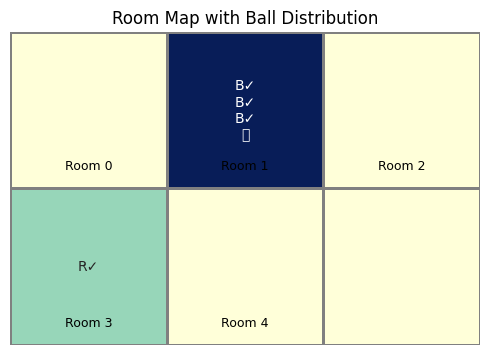

📌 Posterior belief: μ = 3.67, σ = 0.0017

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


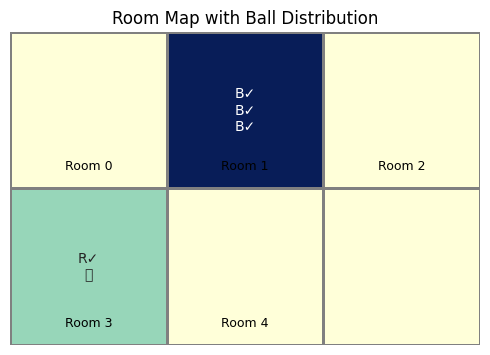

📌 Posterior belief: μ = 3.67, σ = 0.0017

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


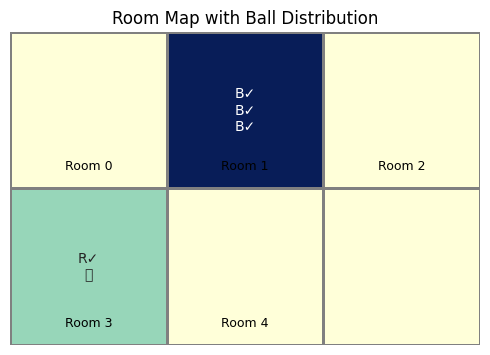

📌 Posterior belief: μ = 3.67, σ = 0.0017

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


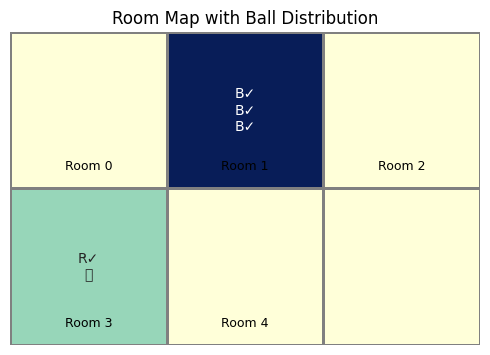

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4] 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


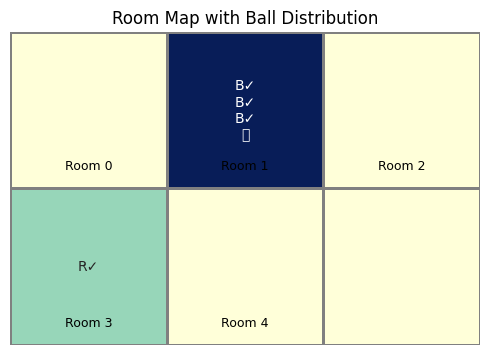

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4]

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


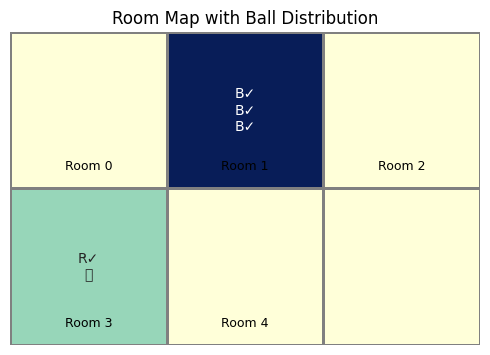

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [0, 2] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


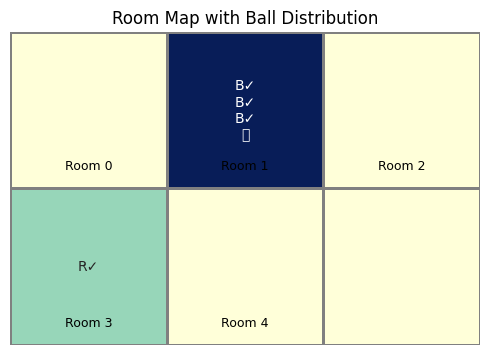

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [2, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


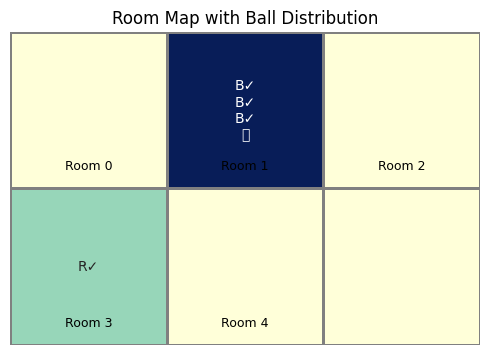

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [0, 2] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


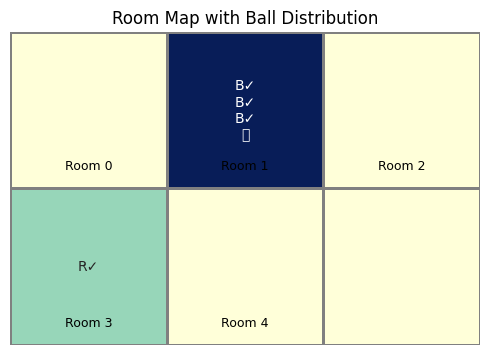

📌 Posterior belief: μ = 3.67, σ = 0.0016

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 4] | Empty: [4] | Memory(Blue): [1]
--------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


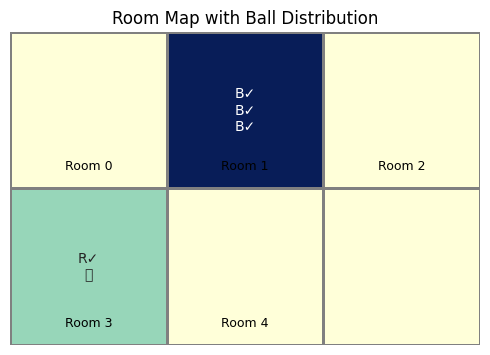

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
--------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


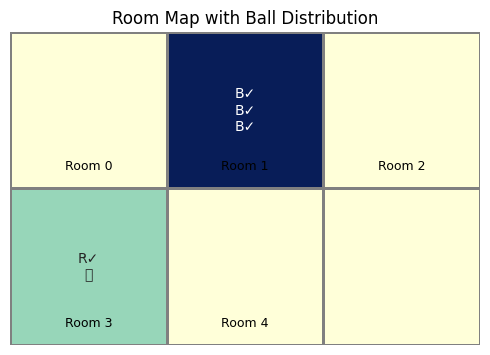

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2] | Empty: [0, 2] | 

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


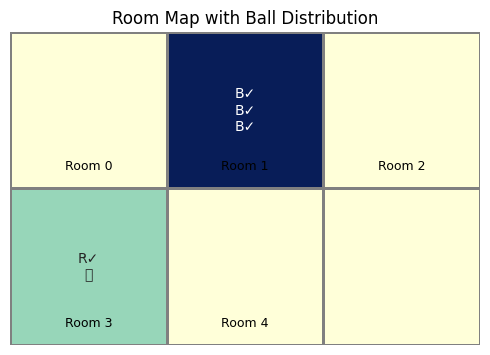

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 4] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 3 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [2, 4] | Me

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


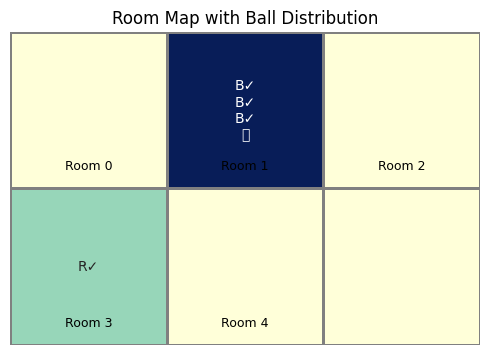

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 3, 4] | Empty: [4] | Memory(Blue): [1]
------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


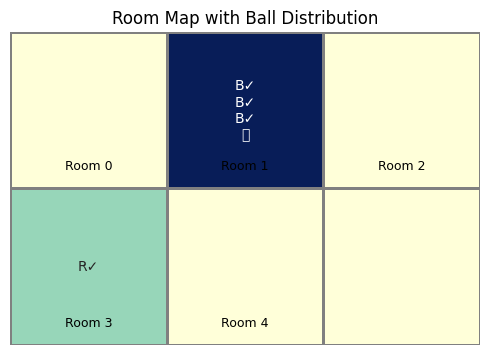

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

🙈 No balls detected in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 1] | Empty: [2] | Memory(Blue): [1]
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.85
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1, 2] | Empty: [2] | Memory(Blue): [1]
---------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


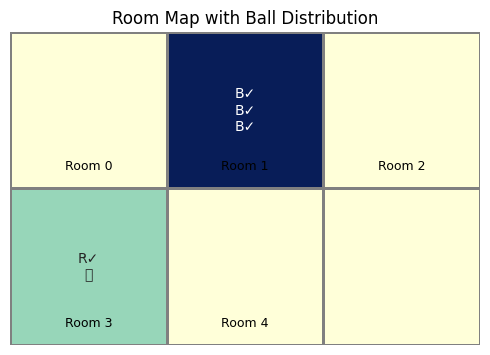

📌 Posterior belief: μ = 3.67, σ = 0.0015

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 3
   🎯 Found new ball: RED (ID 3)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 3
🔄 STEP 2 — Moved from Room 3 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: 0.90
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 3] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 3 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 3] | Empty: [2, 4] | Memo

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


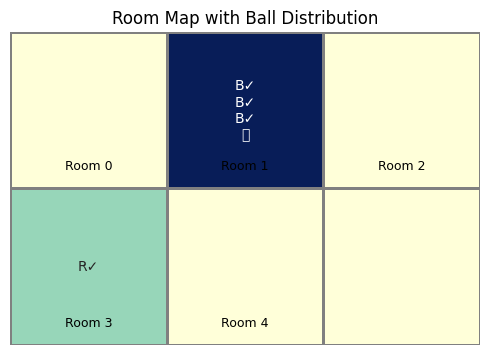

📌 Posterior belief: μ = 3.67, σ = 0.0014

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.95
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 2 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 1)
   💰 Reward: 0.95 | Total: 1.90
   ✅ Balls found: 2 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
---------------------------------------------------

👁️  Detected possible BLUE ball in Room 1
🔄 STEP 3 — Moved from Room 1 → Room 1
   🎯 Found new ball: BLUE (ID 2)
   💰 Reward: 0.95 | Total: 2.85
   ✅ Balls found: 3 / 4
   🗺️  Visited: [0, 1] | Empty: [] | Memory(Blue): [1]
-------------------------------------

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


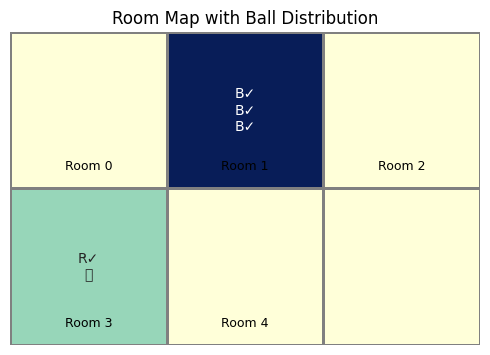

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📌 Posterior belief: μ = 3.67, σ = 0.0014

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 2
   😐 No new balls found in this room
   🧱 Marking Room 2 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [2] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 2
🔄 STEP 2 — Moved from Room 2 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 2] | Empty: [2, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 3 — Moved from Room 4 → Room 1
   🎯 Found new ball: BLUE (ID 0)
   💰 Reward: 0.95 | Total: 0.85
   ✅ Balls found: 1 / 4
   🗺️  Visited: [0, 2, 4] | Empty: [2, 4]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


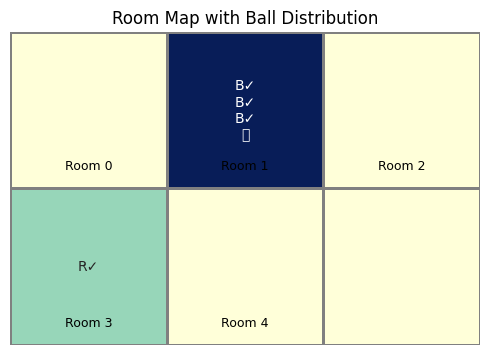

📌 Posterior belief: μ = 3.67, σ = 0.0014

🧪 Initial ball positions:
   Ball 0: BLUE in Room 1
   Ball 1: BLUE in Room 1
   Ball 2: BLUE in Room 1
   Ball 3: RED in Room 3

🚀 Robot starting in Room 0

🙈 No balls detected in Room 0
🔄 STEP 1 — Moved from Room 0 → Room 4
   😐 No new balls found in this room
   🧱 Marking Room 4 as empty.
   💰 Reward: -0.05 | Total: -0.05
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0] | Empty: [4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 4
🔄 STEP 2 — Moved from Room 4 → Room 0
   😐 No new balls found in this room
   🧱 Marking Room 0 as empty.
   💰 Reward: -0.05 | Total: -0.10
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0, 4] | Memory(Blue): []
---------------------------------------------------

🙈 No balls detected in Room 0
🔄 STEP 3 — Moved from Room 0 → Room 3
   😐 No new balls found in this room
   💰 Reward: -0.05 | Total: -0.15
   ✅ Balls found: 0 / 4
   🗺️  Visited: [0, 4] | Empty: [0,

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


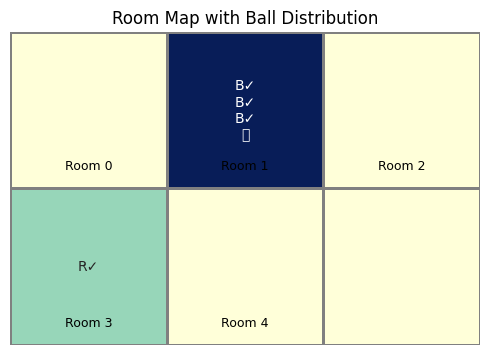

📌 Posterior belief: μ = 3.67, σ = 0.0014
Average reward: 3.6614999999999998
📌 Posterior belief: μ = 3.67, σ = 0.0014


In [163]:
num_episodes = 100
average_reward = 0
average_setps = 0
reward_list = []
est = BayesianRewardEstimator(mu0=3.65, sigma0=0.021, obs_sigma=0.1) # 0.5
print(f"📌 Prior belief: μ₀ = {est.mu:.2f}, σ₀ = {est.sigma2 ** 0.5:.4f}")
for x in range(num_episodes):
    env.found_balls = set()
    state = 0 #env.robot_room 
    total_reward = 0
    steps_taken = 0

    reward, steps = run_policy_with_detection(env, estimator=est)  # Ejecuta sin imprimir logs
    reward_list.append(reward)
    average_reward = average_reward + reward
    average_setps = average_setps + steps
    print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")
        
print("Average reward: "+ str(average_reward/num_episodes))
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")

In [164]:
print("Average reward: "+ str(average_reward/num_episodes))
print("Average steps: "+ str(average_setps/num_episodes))
print(f"📌 Posterior belief: μ = {est.mu:.2f}, σ = {est.sigma2 ** 0.5:.4f}")
print("real obs sigma: "+str(calculate_obs_sigma(reward_list)))

Average reward: 3.6614999999999998
Average steps: 6.77
📌 Posterior belief: μ = 3.67, σ = 0.0014
real obs sigma: 0.07812674240481206


## TRAINING Q TABLE

In [158]:
import random
import numpy as np

est_qtable = BayesianRewardEstimator(mu0=0.0, sigma0=1.5, obs_sigma=0.1)
print(f"📌 Prior belief: μ₀ = {est_qtable.mu:.2f}, σ₀ = {est_qtable.sigma2 ** 0.5:.4f}")
q_table = np.zeros((env.num_rooms, env.num_rooms))  # Q[state, action]
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.2   # exploration rate
episodes = 500    # ⬅️ solo 5 episodios

#env = BallEnv()
max_steps = 100
for episode in range(episodes):
    #state = env.reset()
    # RESET NUMBER OF BALLS FOUND
    env.found_balls = set()
    state = 0 #env.robot_room 
    total_reward = 0
    steps_taken = 0

    for step in range(max_steps):
        if random.random() < epsilon:
            action = random.randint(0, env.num_rooms - 1)
        else:
            action = np.argmax(q_table[state])

        # ✅ Corrección:
        next_state, reward, done, _ = env.step(action)
        #est_qtable.update(reward)
        total_reward += reward

        # Q-learning update
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = old_value + alpha * (reward + gamma * next_max - old_value)
        q_table[state, action] = new_value

        state = next_state
        steps_taken += 1

        if done:
            break

    #print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Steps Taken = {steps_taken}")

est_qtable.update(total_reward)
q_table
print("total reward: " + str(total_reward))
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

📌 Prior belief: μ₀ = 0.00, σ₀ = 1.5000
update belief finish
total reward: 3.55
📌 Posterior belief: μ = 3.53, σ = 0.0998


## Q TABLE HEATMAP

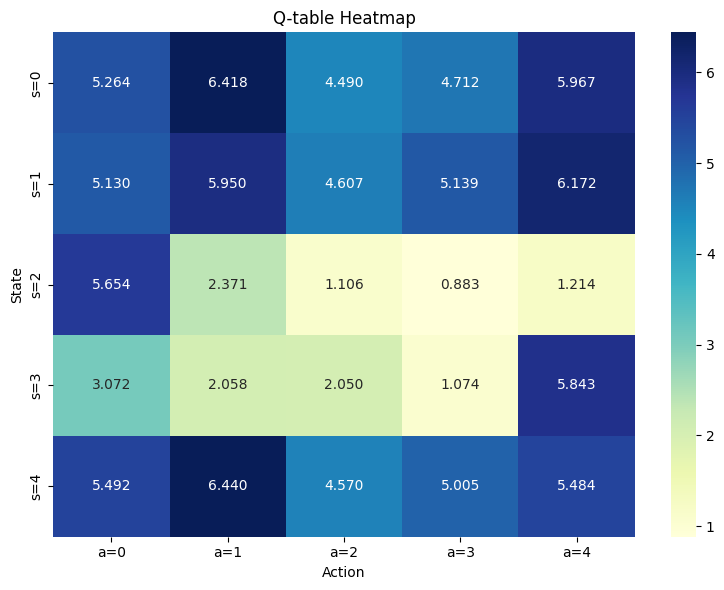

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tu Q-table (puedes reemplazar esto con la tuya si ya está entrena

# Crear un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(q_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar=True,
            xticklabels=[f"a={i}" for i in range(q_table.shape[1])],
            yticklabels=[f"s={i}" for i in range(q_table.shape[0])])

plt.title("Q-table Heatmap")
plt.xlabel("Action")
plt.ylabel("State")
plt.tight_layout()
plt.show()


## PLOT BALL DISTRIBUTION OF EXPERIMENT SETUP

/var/folders/f0/dktnxt157hbb64vbpkxd5h6c0000gn/T/ipykernel_67763/3443168534.py:49: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


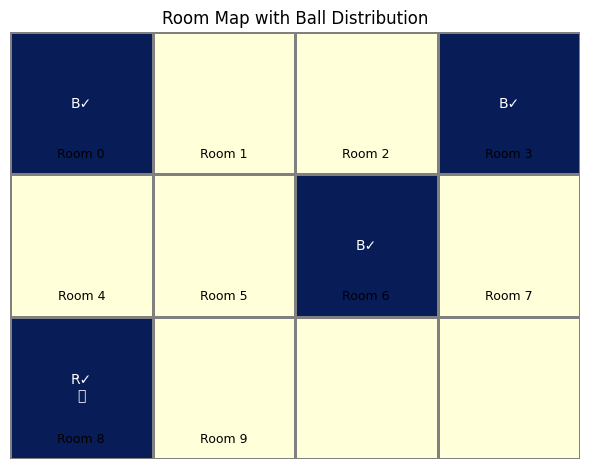

In [10]:
plot_room_ball_distribution(env)

## Calculate EU for some state action

In [11]:
def expected_utility(state, action, q_table, env, gamma=0.9):
    # Simulate what would happen by taking that action
    next_state = action  # action is the room to move to
    move_penalty = -0.05

    # Estimate detection reward (if a ball is present and detected)
    has_ball = any(
        room == next_state and i not in env.found_balls
        for i, (_, room) in enumerate(env.balls)
    )
    expected_reward = move_penalty
    if has_ball:
        expected_reward += env.p_detect * 1.0  # expected ball reward

    future_utility = gamma * np.max(q_table[next_state])
    return expected_reward + future_utility


In [12]:
u = expected_utility(state=0, action=1, q_table=q_table, env=env)
print(f"Expected utility of moving from Room 0 to 1: {u:.2f}")


Expected utility of moving from Room 0 to 1: -0.09


## GET AVERAGE REWARD OVER MANY TIMES RUNNING POLICY 1

In [79]:
# dont trust this
def experiment_average_total_reward(env_class, runs=20, max_steps=50):
    total_rewards = []

    for _ in range(runs):
        #env = env_class()
        env.set_blue_cluster_prob(0.9)
        env.set_detection_params(p_detect=0.9, p_explore=0.1)
        state = env.reset()

        total_reward = 0
        steps_taken = 0
        done = False

        while steps_taken < max_steps and not done:
            detection = env.detect_ball()
            if detection and detection[1] == 'blue':
                if random.random() < env.p_explore:
                    next_room = random.choice([r for r in range(env.num_rooms) if r != state])
                else:
                    next_room = state
            elif detection:
                next_room = state
            else:
                next_room = random.choice([r for r in range(env.num_rooms) if r != state])

            state, reward, done, _ = env.step(next_room)
            total_reward += reward
            steps_taken += 1

        total_rewards.append(total_reward)

    average_reward = sum(total_rewards) / runs
    return average_reward, total_rewards

# Ejecutar experimento con N repeticiones
avg_reward, all_rewards = experiment_average_total_reward(BallEnvDetectable, runs=2000, max_steps=50)
avg_reward
# first value is the averate total reward over experiments.

0.3185

## Q learning over many episodes average

In [175]:
def experiment_average_total_reward_q(env_class, q_table, runs=20, max_steps=50):
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.09)
    est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=1.5, obs_sigma=0.3)


    total_rewards = []
    total_steps = []
    average_steps = 0

    for _ in range(runs):
        '''
        env = env_class()
        env.set_blue_cluster_prob(0.9)
        env.set_detection_params(p_detect=0.9, p_explore=0.1)
        
        # Opcional: fully connect env
        env.set_connections({i: list(range(env.num_rooms)) for i in range(env.num_rooms)})
        '''
        # Para resetear las posiciones de las bolas aleatoriamente.
        #env.balls = []
        #env.reset()
        
        state = 0
        total_reward = 0
        steps_taken = 0
        env.found_balls = set()
        done = False

        while steps_taken < max_steps and not done:
            # Elegir acción con mejor Q-value
            next_room = int(np.argmax(q_table[state]))

            # Si no hay conexión, elegir al azar (fallback)
            if next_room not in env.connections[state]:
                candidates = [r for r in env.connections[state] if r != state]
                next_room = random.choice(candidates) if candidates else state

            state, reward, done, _ = env.step(next_room)
            total_reward += reward
            steps_taken += 1

        total_rewards.append(total_reward)
        total_steps.append(steps_taken)
        print(total_reward)
        est_qtable.update(total_reward)
        
    average_reward = sum(total_rewards) / runs
    average_steps = sum(total_steps) / runs
    
    return average_reward, total_rewards, average_steps


avg_q, rewards_q , average_steps= experiment_average_total_reward_q(BallEnvDetectable, q_table, runs=10)
print(f"📊 Q-policy average reward: {avg_q:.2f}")
print("Average number of steps: "+str(average_steps))
#est_qtable.update(avg_q)
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

0.5000000000000013
update belief finish
0.5000000000000013
update belief finish
0.5000000000000013
update belief finish
0.5000000000000013
update belief finish
0.5000000000000013
update belief finish
0.5000000000000009
update belief finish
0.5000000000000013
update belief finish
0.5000000000000013
update belief finish
0.5000000000000004
update belief finish
0.5000000000000013
update belief finish
📊 Q-policy average reward: 0.50
Average number of steps: 50.0
📌 Posterior belief: μ = 3.53, σ = 0.0998



📊 Q-policy average reward: 0.50
Average number of steps: 50.0
📌 Posterior belief: μ = 0.57, σ = 0.0133


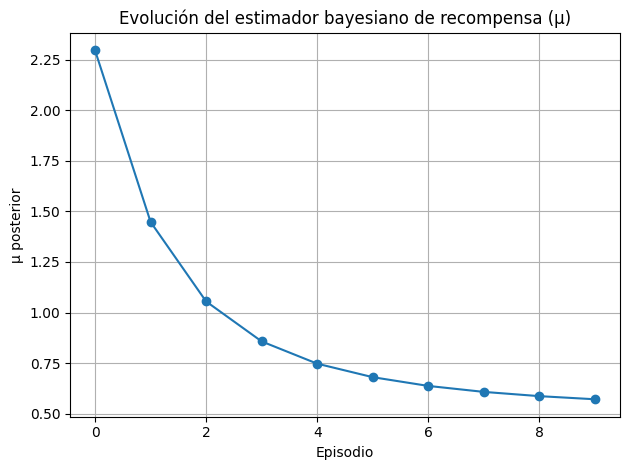

In [185]:
import random
import numpy as np
import matplotlib.pyplot as plt



def experiment_average_total_reward_q(env, q_table, runs=20, max_steps=50):
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=1.5, obs_sigma=0.3)
    #est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.09)
    est_qtable = BayesianRewardEstimator(mu0=3.75, sigma0=0.09, obs_sigma=0.1)

    total_rewards = []
    total_steps = []
    mu_evolution = []

    for _ in range(runs):
        state = 0
        total_reward = 0
        steps_taken = 0
        env.found_balls = set()
        done = False

        while steps_taken < max_steps and not done:
            next_room = int(np.argmax(q_table[state]))

            # Si no hay conexión, fallback aleatorio
            if next_room not in env.connections[state]:
                candidates = [r for r in env.connections[state] if r != state]
                next_room = random.choice(candidates) if candidates else state

            state, reward, done, _ = env.step(next_room)
            total_reward += reward
            steps_taken += 1

        total_rewards.append(total_reward)
        total_steps.append(steps_taken)

        #print(total_reward)
        est_qtable.update(total_reward)
        mu_evolution.append(est_qtable.mu)

    average_reward = sum(total_rewards) / runs
    average_steps = sum(total_steps) / runs

    return average_reward, total_rewards, average_steps, est_qtable, mu_evolution


# 🔁 Ejecutar experimento
avg_q, rewards_q, average_steps, est_qtable, mu_evolution = experiment_average_total_reward_q(
    env=env,  # tu entorno ya creado (BallEnvDetectable)
    q_table=q_table,
    runs=10
)

# 📈 Mostrar resultados
print(f"\n📊 Q-policy average reward: {avg_q:.2f}")
print("Average number of steps:", average_steps)
print(f"📌 Posterior belief: μ = {est_qtable.mu:.2f}, σ = {est_qtable.sigma2 ** 0.5:.4f}")

# 📉 Gráfico evolución de μ
plt.plot(mu_evolution, marker='o')
plt.title("Evolución del estimador bayesiano de recompensa (μ)")
plt.xlabel("Episodio")
plt.ylabel("μ posterior")
plt.grid(True)
plt.tight_layout()
plt.show()


In [187]:
def compute_score(mu, sigma, steps):
    return mu / (steps * sigma)

score_policy1 = compute_score(3.65, 0.01, 6.77)
score_q = compute_score(0.56, 0.01, 50)

print("Policy 1 Score:", score_policy1)
print("Q Policy Score:", score_q)

best_policy = "Policy 1" if score_policy1 > score_q else "Q Policy"
print(f"Best policy to use: {best_policy}")


Policy 1 Score: 53.91432791728213
Q Policy Score: 1.12
Best policy to use: Policy 1
